In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_df = pd.read_csv('../input/covidx-cxr2/train.txt', sep=" ", header=None)

train_df.columns=['patient id', 'filename', 'class', 'data source']

train_df=train_df.drop(['patient id', 'data source'], axis=1 )

In [3]:
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [4]:
train_df.head() # see the first 5 rows and columns of train

,filename,class
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


In [5]:
test_df.head()#see the first 5 columns for test

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [6]:
train_path = '../input/covidx-cxr2/train/'  #directory path
test_path = '../input/covidx-cxr2/test/'

In [7]:
train_df['class'].value_counts()

positive    16490
negative    13992
Name: class, dtype: int64

In [9]:
negative  = train_df[train_df['class']=='negative']   #negative values in class column
positive = train_df[train_df['class']=='positive']  #positive values in class column
from sklearn.utils import resample
#majority class that  is negative, we need to downsample/decrease that class so that there is no bias
#n_samples = 2158 means we want 2158 sample of class negative, since there are 2158 samples of class positive
df_majority_downsampled = resample(negative, replace = True, n_samples = 2158) 
#concatenate
train_df = pd.concat([positive, df_majority_downsampled])

from sklearn.utils import shuffle
train_df = shuffle(train_df) # shuffling so that there is particular sequence

In [10]:
train_df['class'].value_counts()

positive    16490
negative     2158
Name: class, dtype: int64

In [11]:
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

In [12]:


print(f"Negative and positive values of train: {train_df['class'].value_counts()}")
print(f"Negative and positive values of validation: {valid_df['class'].value_counts()}")
print(f"Negative and positive values of test: {test_df['class'].value_counts()}")

Negative and positive values of train: positive    14848
negative     1935
Name: class, dtype: int64
Negative and positive values of validation: positive    1642
negative     223
Name: class, dtype: int64
Negative and positive values of test: positive    200
negative    200
Name: class, dtype: int64


In [13]:


train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory=train_path, x_col='filename', 
                                              y_col='class', target_size=(200,200), batch_size=64, 
                                               class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_df, directory=train_path, x_col='filename',
                                             y_col='class', target_size=(200,200), batch_size=64, 
                                            class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_path, x_col='filename', 
                                            y_col='class', target_size=(200,200), batch_size=64,
                                             class_mode='binary')
#class mode binary because we want the classifier to predict covid or not
#target size (200,200) means we want the images to resized to 200*200

Found 16783 validated image filenames belonging to 2 classes.
Found 1865 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


Now start the transfer learning!

In [14]:
import tensorflow as tf

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
for layer in base_model.layers:
    layer.trainable = False

94674944/94668760 [==============================] - 1s 0us/step


# Model building

In [15]:


model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("covid_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


In [17]:
#CHANGE BACK TO 20 EPOCHS
history = model.fit(train_gen, 
                    validation_data=valid_gen, epochs=5, 
                    callbacks=[callbacks])

Epoch 1/5
263/263 [==============================] - 585s 2s/step - loss: 0.3261 - accuracy: 0.8745 - val_loss: 0.1856 - val_accuracy: 0.9351
Epoch 2/5
263/263 [==============================] - 350s 1s/step - loss: 0.1759 - accuracy: 0.9295 - val_loss: 0.1543 - val_accuracy: 0.9340
Epoch 3/5
263/263 [==============================] - 351s 1s/step - loss: 0.1572 - accuracy: 0.9331 - val_loss: 0.1567 - val_accuracy: 0.9362
Epoch 4/5
263/263 [==============================] - 351s 1s/step - loss: 0.1512 - accuracy: 0.9372 - val_loss: 0.1583 - val_accuracy: 0.9357

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/5
263/263 [==============================] - 351s 1s/step - loss: 0.1439 - accuracy: 0.9400 - val_loss: 0.1604 - val_accuracy: 0.9346
Epoch 00005: early stopping


# Model evaluation and predictions

In [18]:
model.load_weights('./covid_classifier_model.h5')
model.evaluate(test_gen)

7/7 [==============================] - 39s 6s/step - loss: 0.3970 - accuracy: 0.8350


[0.39698219299316406, 0.8349999785423279]

In [19]:
preds = (model.predict(test_gen)>0.5).astype("int32")

preds

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
    

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

AttributeError: 'NoneType' object has no attribute 'shape'

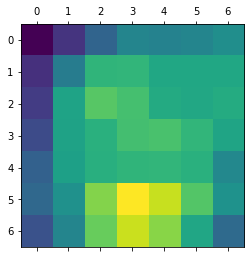

In [22]:
import torch
import torch.nn as nn
from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2


# ResNet Class
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = resnet152(pretrained=True)
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

      
# all the data transformation and loading
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#FIND DATASET FOLDER PATH
dataset = ImageFolder(root='../input/covidx-cxr2', transform=transform)
dataloader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

# init the resnet
resnet = ResNet()

# set the evaluation mode
_ = resnet.eval()

# get the image
img, _ = next(iter(dataloader))

# forward pass
pred = resnet(img)

pred.argmax(dim=1)  # prints tensor([2])

# get the gradient of the output with respect to the parameters of the model
pred[:, 2].backward()

# pull the gradients out of the model
gradients = resnet.get_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resnet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

# make the heatmap to be a numpy array
heatmap = heatmap.numpy()

# interpolate the heatmap
img = cv2.imread("/kaggle/input/covidx-cxr2/train/")
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./gradcam/', superimposed_img)